In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
# data manipulation
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.filterwarnings(action = 'ignore')
from IPython.display import clear_output

# nlp
import string
import regex as re
import spacy

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
!python -m spacy download en_core_web_sm
clear_output()

In [4]:
# loading the dataset
data = pd.read_csv('/content/drive/MyDrive/Ecommerce_text_classification/ecommerceDataset.csv', names = ['label', 'description'])

In [5]:
data.head()

,label,description
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50425 entries, 0 to 50424
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   label        50425 non-null  object
 1   description  50424 non-null  object
dtypes: object(2)
memory usage: 788.0+ KB


In [7]:
# checking for missing values and duplicates

print('number of missing values in the dataset are:', data['description'].isnull().sum())
print('number of duplicates rows in the dataset are:', len(data) - len(data.drop_duplicates()))

number of missing values in the dataset are: 1
number of duplicates rows in the dataset are: 22622


In [8]:
# drop missing values and duplicates rows 

data.dropna(inplace = True)
data.drop_duplicates(inplace = True)

In [9]:
data.shape

(27802, 2)

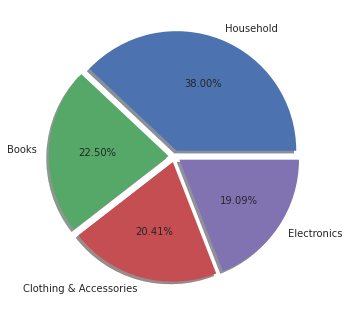

In [10]:
# composition of labels
with plt.style.context('seaborn'):
  labels_composition = data['label'].value_counts()
  plt.pie(labels_composition, autopct = '%.2f%%', labels = labels_composition.index, explode = [0.05, 0.05, 0.05, 0.05], shadow = True)

In [11]:
def word_cloud(data, ecommerce_type):
  ''' 
      Input:
        data : dataset
        cancer_type : type of cancer  
      Return: wordcloud generator  
   '''
  ecommerce_data = data.loc[data['label'] == ecommerce_type]
  stopwords = set(STOPWORDS)
  tokens = ecommerce_data['description'].apply(lambda x: ' '.join([i.lower() for i in x.split() if i not in stopwords]))

  wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2500,
                      height=2000
                      ).generate(" ".join(tokens))
  return wordcloud

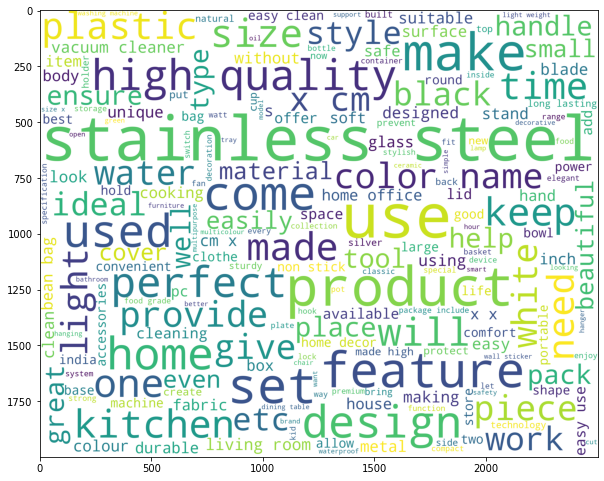

In [12]:
plt.figure(figsize = (10, 10))
plt.imshow(word_cloud(data, 'Household'));

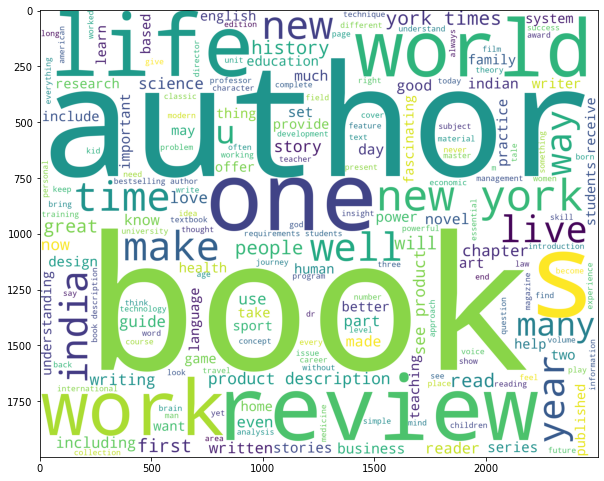

In [13]:
plt.figure(figsize = (10, 10))
plt.imshow(word_cloud(data, 'Books'));

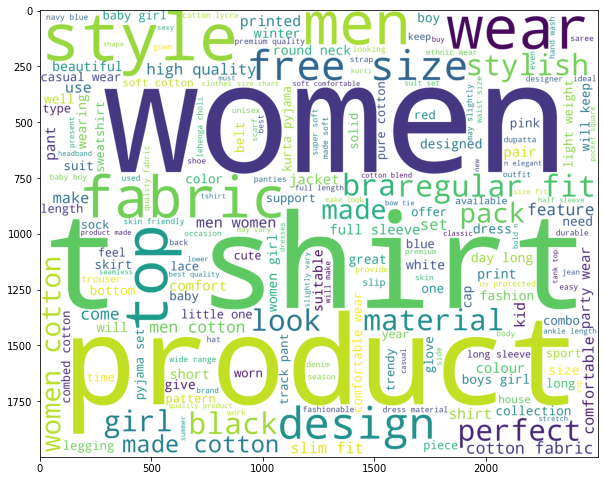

In [14]:
plt.figure(figsize = (10, 10))
plt.imshow(word_cloud(data, 'Clothing & Accessories'));

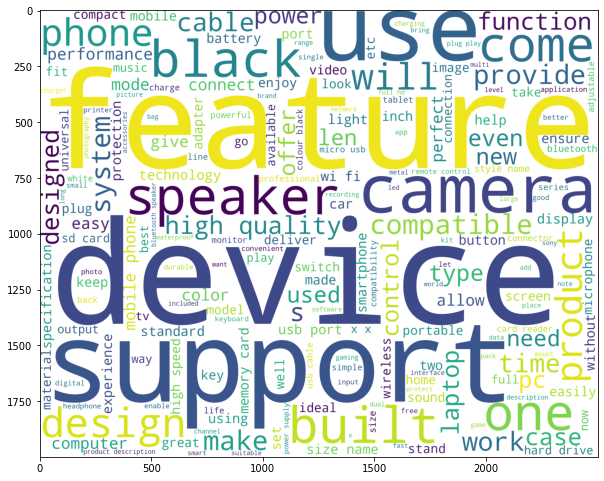

In [15]:
plt.figure(figsize = (10, 10))
plt.imshow(word_cloud(data, 'Electronics'));

In [16]:
# distribution of number of words in descriptions 
def words_distribution(data, ecommerce_type):
  ecommerce_data = data.loc[data['label'] == ecommerce_type, :]
  sns.distplot(ecommerce_data['description'].apply(lambda x: len(x.split())))
  plt.title(f'Class: {ecommerce_type}')

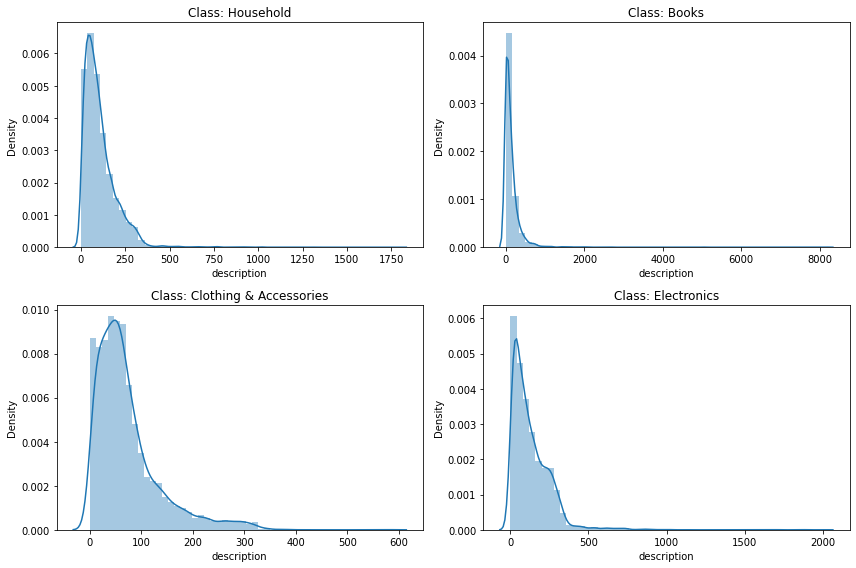

In [17]:
plt.figure(figsize = (12, 8))
plt.subplot2grid((4, 4), (0, 0), rowspan = 2, colspan = 2)
words_distribution(data, 'Household')

plt.subplot2grid((4, 4), (0, 2), rowspan = 2, colspan = 2)
words_distribution(data, 'Books')

plt.subplot2grid((4, 4), (2, 0), rowspan = 2, colspan = 2)
words_distribution(data, 'Clothing & Accessories')

plt.subplot2grid((4, 4), (2, 2), rowspan = 2, colspan = 2)
words_distribution(data, 'Electronics')

plt.tight_layout()

In [18]:
label_dict = {'Household': 1, 'Books': 2, 'Clothing & Accessories': 3, 'Electronics': 4}
data.replace({'label': label_dict}, inplace = True)

In [19]:
# splitting data to train, validation, and test
X, y = data.drop(columns = ['label']), data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 27)
train_data = pd.concat([X_train, y_train], axis = 1)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 27)
val_data, test_data = pd.concat([X_val, y_val], axis = 1), pd.concat([X_test, y_test], axis = 1)

In [20]:
print(f"train_data size: {train_data.shape}, validation_data size: {val_data.shape}, test_data size:{test_data.shape}")

train_data size: (22241, 2), validation_data size: (2780, 2), test_data size:(2781, 2)


In [21]:
def convert_to_lowercase(text):
  return text.lower()

In [22]:
def remove_whitespace(text):
  return text.strip()

In [23]:
def remove_punctuation(text):
  punctuations = string.punctuation
  punctuations = punctuations.replace("'", "")
  return text.translate(str.maketrans('', '', punctuations))

In [24]:
def remove_html(text):
  html = re.compile(r'<.*?>')
  return html.sub(r'', text)

In [25]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [26]:
def remove_http(text):
  http = 'https?://\S+|www\.\S+'
  return re.sub(http, '', text)

In [27]:
contractions_url = 'https://raw.githubusercontent.com/sugatagh/E-commerce-Text-Classification/main/JSON/english_contractions.json'
contractions_dict = pd.read_json(contractions_url, typ = 'series')

contractions_list = list(contractions_dict.keys())

def convert_contractions(text):
  return ' '.join([contractions_dict[i] if i in contractions_list else i for i in text.split()])

In [28]:
acronyms_url = 'https://raw.githubusercontent.com/sugatagh/E-commerce-Text-Classification/main/JSON/english_acronyms.json'
acronyms_dict = pd.read_json(acronyms_url, typ = 'series')

acronyms_list = list(acronyms_dict.keys())

nlp = spacy.load('en_core_web_sm')

def convert_acronyms(sentence):
  return ' '.join([acronyms_dict[i.text] if i.text in acronyms_list else i.text for i in nlp(sentence)  ])

In [29]:
stopwords = set(STOPWORDS)
def remove_stopwords(text):
  return ' '.join([i for i in text.split() if i not in stopwords])

In [30]:
def text_lemmatizer(text):
  return ' '.join([i.lemma_ for i in nlp(text)])

In [31]:
def discard_non_alpha(text):
  return ' '.join([i for i in text.split() if i.isalpha()])

In [32]:
def text_normalizer(text):
  text = convert_to_lowercase(text)
  text = remove_whitespace(text)
  text = re.sub('\n', '', text)
  text = remove_http(text)
  text = remove_html(text)
  text = remove_emoji(text)
  text = remove_punctuation(text)
  text = convert_contractions(text)
  text = convert_acronyms(text)
  text = remove_stopwords(text)

  text = discard_non_alpha(text)
  text = text_lemmatizer(text)

  return text  
  

In [33]:
# normalizing train, validation, and test datasets
data_train_norm, data_val_norm, data_test_norm = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
data_train_norm['normalized_description'] = train_data['description'].apply(text_normalizer)
data_val_norm['normalized_description'] = val_data['description'].apply(text_normalizer)
data_test_norm['normalized_description'] = test_data['description'].apply(text_normalizer)

In [34]:
data_train_norm['label'] = train_data['label']
data_val_norm['label'] = val_data['label']
data_test_norm['label'] = test_data['label']

In [45]:
# save normalized data as csv file 
data_train_norm.to_csv('/content/drive/MyDrive/Ecommerce_text_classification/data_train_norm.csv')

In [42]:
data_val_norm.to_csv('/content/drive/MyDrive/Ecommerce_text_classification/data_val_norm.csv')


In [43]:
data_test_norm.to_csv('/content/drive/MyDrive/Ecommerce_text_classification/data_test_norm.csv')
